In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
tr1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/pd-ds-coh-team1/data/transactions_1.csv')
tr2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/pd-ds-coh-team1/data/transactions_2.csv')
tr3 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/pd-ds-coh-team1/data/transactions_3.csv')

tr = pd.concat([tr1,tr2,tr3])
tr.head(2)

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_0,TRANSFER,AED,4.55,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_4368,2018-04-03 03:34:21.784487
1,transaction_1,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,4111.0,Dubai,ARE,OUTBOUND,user_2355,2019-03-19 06:15:59.537032


In [4]:
usr = pd.read_csv('/content/drive/My Drive/Colab Notebooks/pd-ds-coh-team1/data/users.csv')

In [5]:
tr=tr[(tr['transactions_state']=='COMPLETED') & (tr['amount_usd']>0)]
tr.head(1)

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_0,TRANSFER,AED,4.55,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_4368,2018-04-03 03:34:21.784487


In [6]:
minmaxdate = tr.groupby(['user_id'])['created_date'].agg([min,max])
minmaxdate.head(1)

,min,max
user_id,,
user_0,2018-09-10 18:54:08.965855,2019-05-10 05:09:13.868855


In [7]:
tr['created_date']=pd.to_datetime(tr['created_date'])

In [8]:
distinct_days_of_transaction= tr.copy()
distinct_days_of_transaction['distinct_days_of_transaction'] = distinct_days_of_transaction['created_date'].dt.date
distinct_days_of_transaction = distinct_days_of_transaction.groupby(['user_id'])['distinct_days_of_transaction'].nunique()
distinct_days_of_transaction_final = pd.DataFrame(index=distinct_days_of_transaction.axes,data=distinct_days_of_transaction.values,columns=['distinct_days_of_transaction'])
distinct_days_of_transaction_final.head()

,distinct_days_of_transaction
user_id,
user_0,160
user_1,69
user_10,59
user_100,25
user_1000,15


In [9]:
usr = pd.merge(usr,distinct_days_of_transaction_final,how='left',on='user_id')

In [10]:
usr = pd.merge(usr,minmaxdate,how='left',on='user_id')

In [11]:
usr['created_date']=pd.to_datetime(usr['created_date'])

In [12]:
usr['current_date'] = tr['created_date'].max()

In [13]:
usr['current_date']=pd.to_datetime(usr['current_date'])
usr['min']=pd.to_datetime(usr['min'])
usr['max']=pd.to_datetime(usr['max'])

In [14]:
usr['transactions_period'] = usr['max'] - usr['min']

In [15]:
usr['transactions_period']=usr['transactions_period'].dt.days


In [16]:
usr.head(1)

,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,distinct_days_of_transaction,min,max,current_date,transactions_period
0,user_0,1992,ES,Madrid,2018-09-10 18:46:42.843855,0,STANDARD,1.0,1.0,3,0,0,160.0,2018-09-10 18:54:08.965855,2019-05-10 05:09:13.868855,2019-05-15 21:18:22.660896,241.0


In [17]:
usr['period_in_app'] = usr['current_date'] - usr['created_date']


In [18]:
usr['period_in_app'] = usr['period_in_app'].dt.days

In [19]:
usr.head(1)

,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,distinct_days_of_transaction,min,max,current_date,transactions_period,period_in_app
0,user_0,1992,ES,Madrid,2018-09-10 18:46:42.843855,0,STANDARD,1.0,1.0,3,0,0,160.0,2018-09-10 18:54:08.965855,2019-05-10 05:09:13.868855,2019-05-15 21:18:22.660896,241.0,247


In [20]:
Tmin = usr['min']
Tmax = usr['max']
t = usr['current_date']
c = usr['created_date']

usr['t-Tmax'] = t - Tmax
usr['t-Tmax'] = usr['t-Tmax'].dt.days
usr.head(1)

,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,distinct_days_of_transaction,min,max,current_date,transactions_period,period_in_app,t-Tmax
0,user_0,1992,ES,Madrid,2018-09-10 18:46:42.843855,0,STANDARD,1.0,1.0,3,0,0,160.0,2018-09-10 18:54:08.965855,2019-05-10 05:09:13.868855,2019-05-15 21:18:22.660896,241.0,247,5.0


In [22]:
test = usr.copy()
test['time_usage_percentage'] = test['transactions_period']/(test['period_in_app'] + 24) #ποστό χρόνου χρήσης
test['active_over_inactive'] =  test['transactions_period']/(test['t-Tmax'] + 24) #λόγος ενεργού προς ενεργού χρόνου
test['time_active_usage_percentage'] = test['distinct_days_of_transaction'] / (test['transactions_period'] + 24) #ποσοστό ενεργού χρόνου χρήσης 
test.head(5)
# test['active_over_inactive_norm'] = (test['active_over_inactive'] - test['active_over_inactive'].min())/ (test['active_over_inactive'].max()-test['active_over_inactive'].min())

,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,distinct_days_of_transaction,min,max,current_date,transactions_period,period_in_app,t-Tmax,time_usage_percentage,active_over_inactive,time_active_usage_percentage
0,user_0,1992,ES,Madrid,2018-09-10 18:46:42.843855,0,STANDARD,1.0,1.0,3,0,0,160.0,2018-09-10 18:54:08.965855,2019-05-10 05:09:13.868855,2019-05-15 21:18:22.660896,241.0,247,5.0,0.889299,8.310345,0.603774
1,user_1,1985,LT,Klaipeda,2018-01-11 18:53:10.531146,1,STANDARD,NaN,NaN,75,0,0,69.0,2018-02-04 08:28:17.978146,2019-05-04 02:30:11.492146,2019-05-15 21:18:22.660896,453.0,489,11.0,0.883041,12.942857,0.144654
2,user_2,1996,IE,Carrickmacross,2018-11-29 17:29:16.879324,0,STANDARD,NaN,NaN,71,0,0,64.0,2018-11-29 17:32:47.713324,2019-04-19 19:56:21.441324,2019-05-15 21:18:22.660896,141.0,167,26.0,0.738220,2.820000,0.387879
3,user_3,1981,IE,Dublin,2018-02-17 11:58:08.319664,0,STANDARD,NaN,NaN,219,0,0,80.0,2018-02-25 05:29:47.821664,2019-05-09 21:56:20.924664,2019-05-15 21:18:22.660896,438.0,452,5.0,0.920168,15.103448,0.173160
4,user_4,1992,GB,London,2018-01-08 18:40:21.097856,0,STANDARD,NaN,NaN,0,0,0,34.0,2018-03-08 16:34:04.055856,2019-01-15 21:37:28.168856,2019-05-15 21:18:22.660896,313.0,492,119.0,0.606589,2.188811,0.100890


In [23]:
test.shape

(15544, 22)

In [24]:
#test[test['active_over_inactive_norm'] <= test['active_over_inactive_norm'].mean()].count()
#test['time_active_usage_percentage'].mean()

In [27]:
#ανενεργοί
(test[(test['time_usage_percentage'] < 0.6) & (test['active_over_inactive'] < 0.6) & (test['time_active_usage_percentage'] < 0.08) ]).shape

(2040, 22)

In [ ]:
#Με βάση την ροή τους θα μπορούσε να είναι ενεργοί αλλά χρησιμοποιούν πολυ σπάνια την εφαρμογή (third_metric)
test[(test['time_usage_percentage'] < 0.6) & (test['active_over_inactive'] <0.6) & (test['time_active_usage_percentage'] < 0.08)  & (test['time_active_usage_percentage'] > 0.05) ].shape

(474, 22)

[array([0.06934307, 0.00404858]), array([0.2792354 , 0.59385666])]


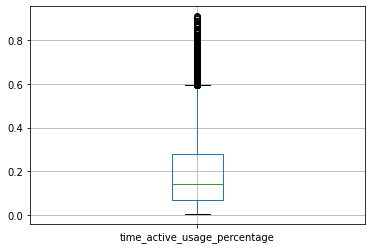

In [28]:
whiskers = test[(test['time_usage_percentage']>0.5) & (test['active_over_inactive']>0.5)].boxplot(column='time_active_usage_percentage',return_type='dict')['whiskers']
print([w.get_ydata() for w in whiskers])

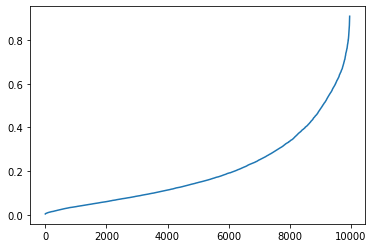

In [29]:
test[(test['time_usage_percentage']>0.6) & (test['active_over_inactive']>0.6)]['time_active_usage_percentage'].sort_values().reset_index(drop=True).plot()

**Clustering**

In [30]:
clust = test.copy()

In [31]:
clust=clust.replace(-np.inf, 0)
clust =clust.replace(np.inf, 0)
clust =clust.replace(np.nan, 0)


clust.dtypes

user_id                                             object
birth_year                                           int64
country                                             object
city                                                object
created_date                                datetime64[ns]
user_settings_crypto_unlocked                        int64
plan                                                object
attributes_notifications_marketing_push            float64
attributes_notifications_marketing_email           float64
num_contacts                                         int64
num_referrals                                        int64
num_successful_referrals                             int64
distinct_days_of_transaction                       float64
min                                                float64
max                                                float64
current_date                                datetime64[ns]
transactions_period                                float

In [33]:
clust.columns

Index(['user_id', 'birth_year', 'country', 'city', 'created_date',
       'user_settings_crypto_unlocked', 'plan',
       'attributes_notifications_marketing_push',
       'attributes_notifications_marketing_email', 'num_contacts',
       'num_referrals', 'num_successful_referrals',
       'distinct_days_of_transaction', 'min', 'max', 'current_date',
       'transactions_period', 'period_in_app', 't-Tmax',
       'time_usage_percentage', 'active_over_inactive',
       'time_active_usage_percentage'],
      dtype='object')

In [34]:
clust_test = clust.drop(['user_id', 'birth_year', 'country', 'city', 'created_date',
       'user_settings_crypto_unlocked', 'plan',
       'attributes_notifications_marketing_push',
       'attributes_notifications_marketing_email', 'num_contacts',
       'num_referrals', 'num_successful_referrals',
       'distinct_days_of_transaction', 'min', 'max', 'current_date',
       'transactions_period', 'period_in_app', 't-Tmax',],axis=1)

In [35]:
from sklearn.preprocessing import StandardScaler
sc = MinMaxScaler()
X = sc.fit_transform(clust_test) 
for k in range(2,5):
    kmeans = KMeans(n_clusters = k, n_init=30, random_state=1000)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("For k =", k, "The average silhouette_score is :", silhouette_avg)

For k = 2 The average silhouette_score is : 0.5766838340746612
For k = 3 The average silhouette_score is : 0.4546384112039394
For k = 4 The average silhouette_score is : 0.4594762261165246


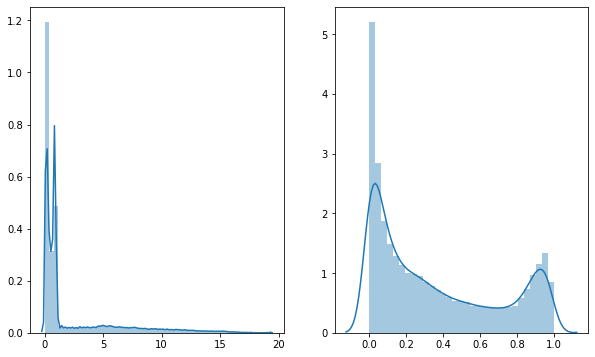

In [36]:
plt.figure(figsize=(10,6))

ax=plt.subplot(121)
sns.distplot((clust_test.iloc[:10000,:]),hist=True)

ax=plt.subplot(122)
sns.distplot(sc.fit_transform(X),hist=True)


In [37]:
k_u = 2
kmeans_cust = KMeans(n_clusters = k_u, n_init=30, random_state=1000)
cust_clusters = kmeans_cust.fit_predict(X)

centroids =sc.inverse_transform(np.array(kmeans_cust.cluster_centers_))

pd.DataFrame(centroids, columns=clust_test.columns[:])


,time_usage_percentage,active_over_inactive,time_active_usage_percentage
0,0.870670,0.381463,0.225655
1,0.181938,0.024576,0.088073


In [ ]:
X

In [38]:
length=0
count=0
for idx,i in enumerate(cust_clusters):
  if i==0:
    length +=1
    count += X[idx,0]
print(count/length)
    

0.8707742543822876


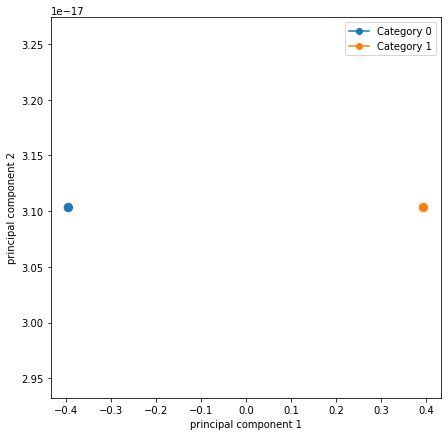

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

centers_principalComponents = pca.fit_transform(kmeans_cust.cluster_centers_)
centers_principalDf = pd.DataFrame(data = centers_principalComponents
             , columns = ['principal component 1', 'principal component 2'])

import matplotlib.lines as mlines

colors = ['C' + str(i) for i in range(2)]
labels = ['Category ' + str(i) for i in range(2)]

ax1 = centers_principalDf.plot(kind='scatter', x='principal component 1', y='principal component 2', 
                               color=colors, s=70, figsize=(7,7))

handles = [plt.Line2D((0,0),(0,0), color='C' + str(i), marker='o', label='Category ' + str(i)) for i in range(2)]    
    
plt.legend(handles=handles)

In [40]:
X = sc.fit_transform(clust_test.values)

kmeansModel = KMeans(n_clusters = 2, init = 'k-means++', random_state = 23)
kmeansModel.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=23, tol=0.0001, verbose=0)

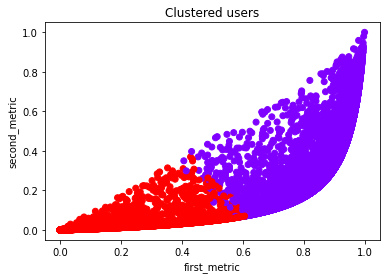

In [41]:
plt.scatter(X[:,0], X[:,1], c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("time_usage_percentage")
plt.ylabel("active_over_inactive")
plt.show()

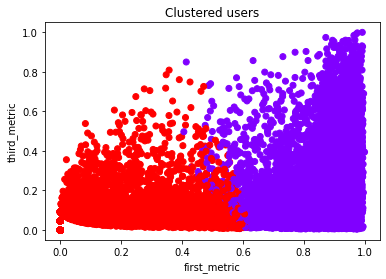

In [42]:
plt.scatter(X[:,0], X[:,2], c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("time_usage_percentage")
plt.ylabel("time_active_usage_percentage")
plt.show()

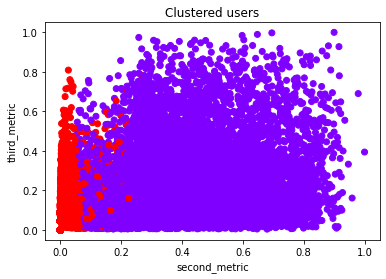

In [43]:
plt.scatter(X[:,1], X[:,2], c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("active_over_inactive")
plt.ylabel("time_active_usage_percentage")
plt.show()